# Compare solvers

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time as mytime

In [ ]:
def ode_system(t, y, D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, D0, I0, E0):
  N,D,I,E= y
                                                                                            # Ref : https://gitlab.com/morpheus.lab/model-repo/-/blob/master/Published%20Models/Principles/Morphodynamics%203/SingleGenotypeCircuit.xml
  Nt_dt = (N0 * (1+(I**p/(I0**p+I**p)))) - (kc * N * D) - (kt * N * D_ext) - gamma * N      # N0*(1+I^p/(I0^p+I^p)) - Kc*N*D - Kt*N*Dn - gamma*N<
  Dt_dt = (D0 * ((I0**p/(I0**p+I**p))))-(kc*N*D)- (kt * N_ext * D) - (gamma * D)            # D0*(I0^p/(I0^p+I^p)) - Kc*N*D - Kt*D*Nn - gamma*D
  It_dt = (kt * N * D_ext) - (gamma_I * I)                                                  # Kt*N*Dn - gammaI*I
  Et_dt = (1 * (I**p/(I0**p+I**p))) - (gamma * E)                                           # I^p/(I0^p+I^p) - gamma*E
  return [Nt_dt, Dt_dt, It_dt, Et_dt]

In [ ]:
def Euler_Solver(p,dt):

  kc = (5*10**(-4))
  kt = (5*10**(-5))
  gamma = 0.1
  gamma_I = 0.5
  N0 = 500
  I0 = 200
  E0 = 1
  D0 = 1000

  N_ext = 2000
  D_ext = 1500

  N, D, I, E , T= [1000], [3000], [0], [0], [0]

  N_ext = 2000
  D_ext = 1500
    # Simulate T-1 timesteps

  num_steps = int((400 - 0) / dt)
  for t in range(0,num_steps):
    I_new = (I[-1]**p)/(I0**p+I[-1]**p)
    I0_new = (I0**p)/(I0**p+I[-1]**p)

    N_t = ((N0 * (1+I_new)) - (kc * N[-1] * D[-1]) - (kt * D_ext * N[-1])  - (gamma* N[-1])) * dt +N[-1]
    D_t = ((D0*I0_new) - (kc * N[-1] * D[-1]) - (kt * N_ext * D[-1]) - (gamma * D[-1])) * dt +D[-1]
    I_t = ((kt * N[-1]*D_ext) - (gamma_I * I[-1])) * dt + I[-1]
    E_t = ((E0 * (I_new)) - (gamma * E[-1])) * dt + E[-1]
    t = T[-1] + dt

    N.append(N_t)
    I.append(I_t)
    D.append(D_t)
    E.append(E_t)
    T.append(t)


  return [N, D, I, E, T]

In [68]:
def compare_solvers(p=2,euler_dt = 0.01,mor_logger = '/content/drive/My Drive/logger_1.csv', steps_compare = 10):

  # Define parameters and inputs
  initial_cond = [1000,3000,0,0]
  N_arr = np.array([])
  D_arr = np.array([])
  I_arr = np.array([])
  E_arr = np.array([])
  t_arr = np.array([])
  kc = (5*10**(-4))
  kt = (5*10**(-5))
  gamma = 0.1
  gamma_I = 0.5
  N0 = 500
  I0 = 200
  E0 = 1
  D0 = 1000
  N_ext = 2000
  D_ext = 1500
  time = (0,400)

  # Run ivp solver
  st_time = mytime.time()
  solution = solve_ivp(ode_system,time, initial_cond, method='LSODA', args=(D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, D0, I0, E0))#,max_step=0.01)
  end_time = mytime.time()
  ivp_time = end_time - st_time
  t_sol = solution.t
  N_sol, D_sol, I_sol, E_sol = solution.y

  # Load Morpheus output
  from google.colab import drive
  drive.mount('/content/drive')
  import pandas as pd
  df = pd.read_csv(mor_logger,sep= "\t")
  t_mor = df.iloc[:,0]
  N_mor = df.iloc[:,2]
  D_mor = df.iloc[:,3]
  I_mor = df.iloc[:,4]
  E_mor = df.iloc[:,5]

  # Run Euler solver
  st_time = mytime.time()
  N_euler, D_euler, I_euler, E_euler, t_euler = Euler_Solver(p,euler_dt)
  end_time = mytime.time()
  euler_time = end_time - st_time

  # Visualize outputs of solvers
  fig, axs = plt.subplots(2, 2)
  header1 = 'Compare full signal with p =' +str(p)+ ' and euler step = ' +str(euler_dt)
  fig.suptitle(header1)
  plt.figure(figsize=(10, 6))
  fig.tight_layout(pad=2.0)
  axs[0, 0].plot(t_sol, N_sol, label='N_sol')
  axs[0, 0].plot(t_mor, N_mor, label='N_mor', linestyle = 'dotted', linewidth=6)
  axs[0, 0].plot(t_euler, N_euler, label='N_euler', linestyle = 'dashed', linewidth=2)
  axs[0, 0].set_xlabel("t")
  axs[0, 0].set_ylabel("N")
  axs[0, 0].legend()
  axs[0, 1].plot(t_sol, D_sol, label='D_sol')
  axs[0, 1].plot(t_mor, D_mor, label='D_mor', linestyle = 'dotted', linewidth=6)
  axs[0, 1].plot(t_euler, D_euler, label='D_euler', linestyle = 'dashed', linewidth=2)
  axs[0, 1].set_xlabel("t")
  axs[0, 1].set_ylabel("D")
  axs[0, 1].legend()
  axs[1, 0].plot(t_sol, I_sol, label='I_sol')
  axs[1, 0].plot(t_mor, I_mor, label='I_mor', linestyle = 'dotted', linewidth=6)
  axs[1, 0].plot(t_euler, I_euler, label='I_euler', linestyle = 'dashed', linewidth=2)
  axs[1, 0].set_xlabel("t")
  axs[1, 0].set_ylabel("I")
  axs[1, 0].legend()
  axs[1, 1].plot(t_sol, E_sol, label='E_sol')
  axs[1, 1].plot(t_mor, E_mor, label='E_mor', linestyle = 'dotted', linewidth=6)
  axs[1, 1].plot(t_euler, E_euler, label='E_euler', linestyle = 'dashed', linewidth=2)
  axs[1, 1].set_xlabel("t")
  axs[1, 1].set_ylabel("E")
  axs[1, 1].legend()

  # Print time elapsed in each solver
  print("ivp_time: ", np.round(ivp_time,4), "euler_time: ", np.round(euler_time,4))

  # Visualize S steps of solvers
  s = steps_compare
  ss = 4
  se = int(1/euler_dt)
  fig2, axs2 = plt.subplots(2, 2)
  header2 = 'Compare '+str(s)+' steps with p =' +str(p)+ ' and euler step = ' +str(euler_dt)
  fig2.suptitle(header2)
  plt.figure(figsize=(10, 6))
  fig2.tight_layout(pad=2.0)
  axs2[0, 0].plot(t_sol[:s*ss], N_sol[:s*ss], label='N_sol')
  axs2[0, 0].plot(t_mor[:s], N_mor[:s], label='N_mor', linestyle = 'dotted', linewidth=6)
  axs2[0, 0].plot(t_euler[:s*se], N_euler[:s*se], label='N_euler', linestyle = 'dashed', linewidth=2)
  axs2[0, 0].set_xlabel("t")
  axs2[0, 0].set_ylabel("N")
  axs2[0, 0].legend()
  axs2[0, 1].plot(t_sol[:s*ss], D_sol[:s*ss], label='D_sol')
  axs2[0, 1].plot(t_mor[:s], D_mor[:s], label='D_mor', linestyle = 'dotted', linewidth=6)
  axs2[0, 1].plot(t_euler[:s*se], D_euler[:s*se], label='D_euler', linestyle = 'dashed', linewidth=2)
  axs2[0, 1].set_xlabel("t")
  axs2[0, 1].set_ylabel("D")
  axs2[0, 1].legend()
  axs2[1, 0].plot(t_sol[:s*ss], I_sol[:s*ss], label='I_sol')
  axs2[1, 0].plot(t_mor[:s], I_mor[:s], label='I_mor', linestyle = 'dotted', linewidth=6)
  axs2[1, 0].plot(t_euler[:s*se], I_euler[:s*se], label='I_euler', linestyle = 'dashed', linewidth=2)
  axs2[1, 0].set_xlabel("t")
  axs2[1, 0].set_ylabel("I")
  axs2[1, 0].legend()
  axs2[1, 1].plot(t_sol[:s*ss], E_sol[:s*ss], label='E_sol')
  axs2[1, 1].plot(t_mor[:s], E_mor[:s], label='E_mor', linestyle = 'dotted', linewidth=6)
  axs2[1, 1].plot(t_euler[:s*se], E_euler[:s*se], label='E_euler', linestyle = 'dashed', linewidth=2)
  axs2[1, 1].set_xlabel("t")
  axs2[1, 1].set_ylabel("E")
  axs2[1, 1].legend()

  # Calculate RMSE error for ivp solver
  t_arr = np.asarray(t_sol)
  idcs = []
  for i in (t_mor):
    idx = (np.abs(t_arr - i)).argmin()
    idcs.append(idx)
  N_error = np.round(np.sqrt((np.mean(np.power(N_sol[idcs] - N_mor,2)))),3)
  D_error = np.round(np.sqrt((np.mean(np.power(D_sol[idcs] - D_mor,2)))),3)
  I_error = np.round(np.sqrt((np.mean(np.power(I_sol[idcs] - I_mor,2)))),3)
  E_error = np.round(np.sqrt((np.mean(np.power(E_sol[idcs] - E_mor,2)))),3)
  print('ivp solver error:', N_error,D_error,I_error,E_error)

  # Calculate RMSE error for euler solver
  t_arr2 = np.asarray(t_euler)
  idcs2 = []
  for i in (t_mor):
    idx2 = (np.abs(t_arr2 - i)).argmin()
    idcs2.append(int(idx2))
  N_euler = np.asarray(N_euler)
  D_euler = np.asarray(D_euler)
  I_euler = np.asarray(I_euler)
  E_euler = np.asarray(E_euler)
  N_error2 = np.round(np.sqrt((np.mean(np.power(N_euler[idcs2] - N_mor,2)))),3)
  D_error2 = np.round(np.sqrt((np.mean(np.power(D_euler[idcs2]  - D_mor,2)))),3)
  I_error2 = np.round(np.sqrt((np.mean(np.power(I_euler[idcs2] - I_mor,2)))),3)
  E_error2 = np.round(np.sqrt((np.mean(np.power(E_euler[idcs2] - E_mor,2)))),3)
  print('Euler solver error:',N_error2,D_error2,I_error2,E_error2)
  return

# Visualizing outputs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ivp_time:  0.0071 euler_time:  0.0022
ivp solver error: 0.489 1.11 0.058 0.003
Euler solver error: 35.3 33.338 2.249 0.004


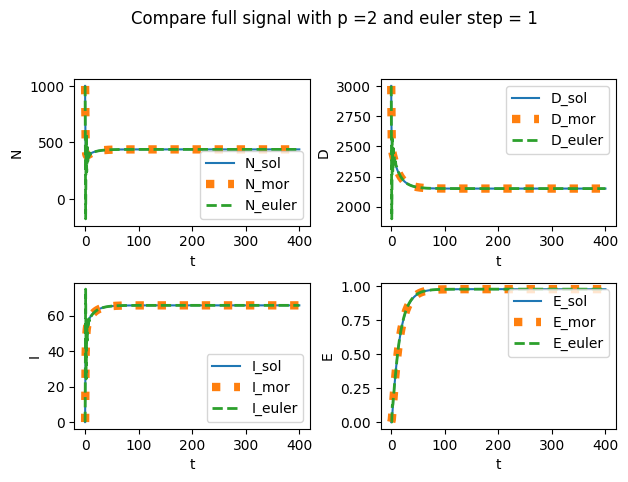

<Figure size 1000x600 with 0 Axes>

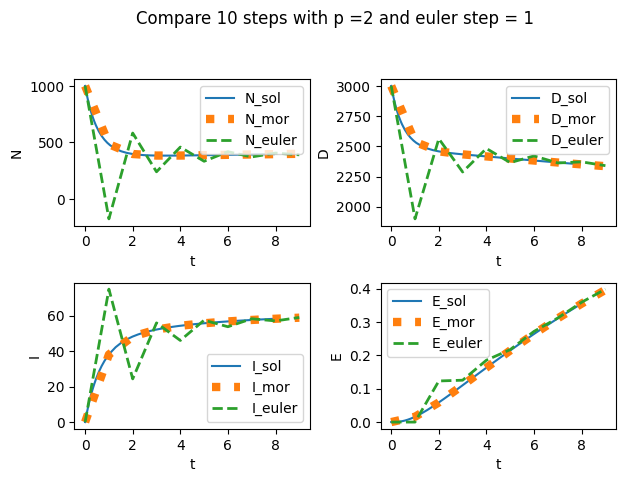

<Figure size 1000x600 with 0 Axes>

In [69]:
compare_solvers(p=2,euler_dt=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ivp_time:  0.0112 euler_time:  0.1007
ivp solver error: 0.489 1.11 0.058 0.003
Euler solver error: 0.09 0.087 0.006 0.0


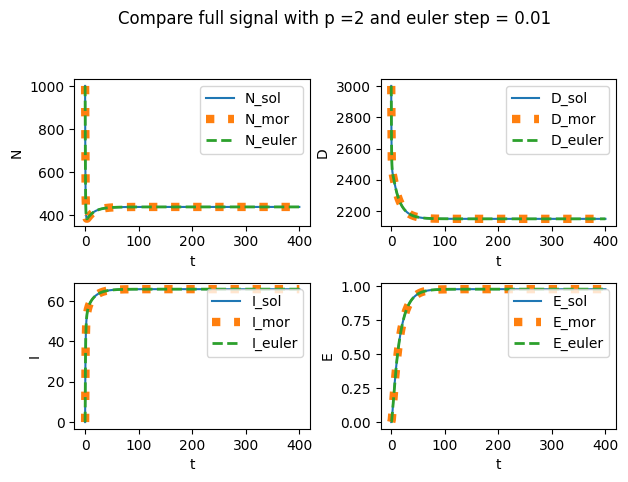

<Figure size 1000x600 with 0 Axes>

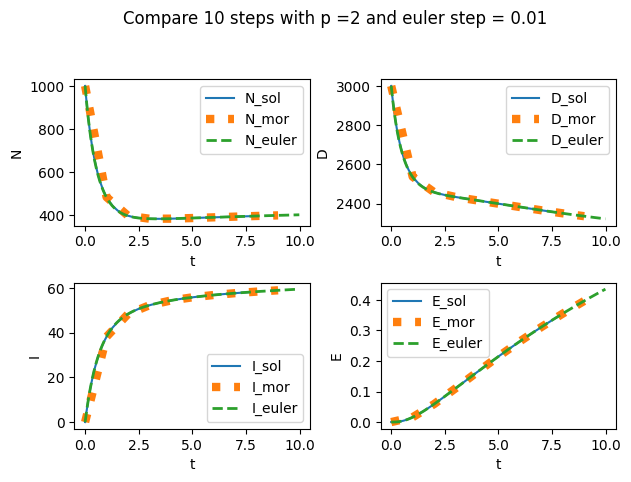

<Figure size 1000x600 with 0 Axes>

In [70]:
compare_solvers(p=2,euler_dt=0.01)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ivp_time:  0.0051 euler_time:  0.105
ivp solver error: 0.184 0.469 0.024 0.0
Euler solver error: 0.091 0.087 0.006 0.0


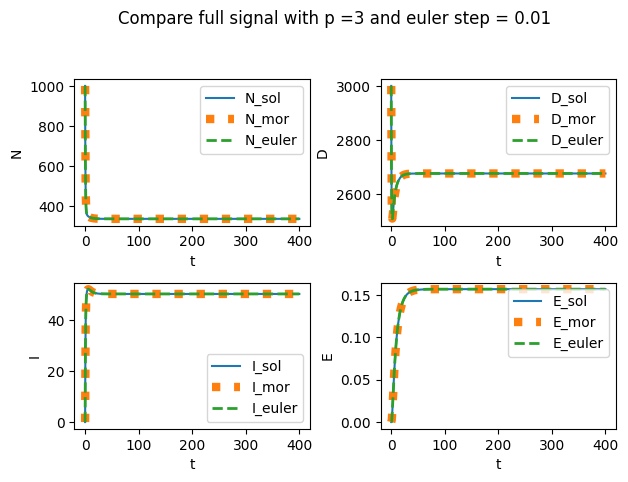

<Figure size 1000x600 with 0 Axes>

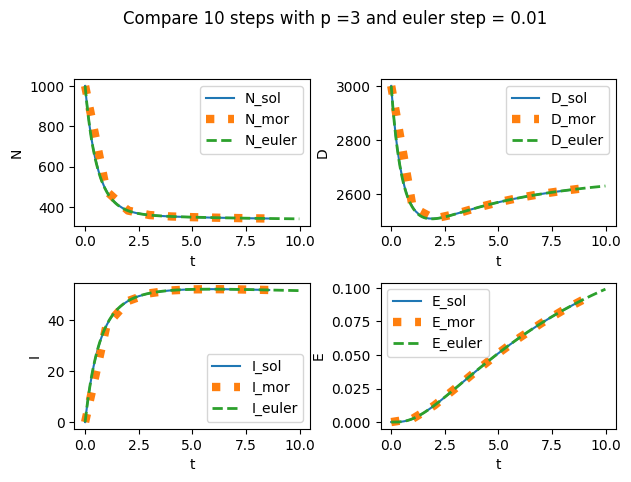

<Figure size 1000x600 with 0 Axes>

In [71]:
compare_solvers(p=3,euler_dt=0.01,mor_logger = '/content/drive/My Drive/logger_p3.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ivp_time:  0.0079 euler_time:  0.2026
ivp solver error: 0.345 0.622 0.034 0.0
Euler solver error: 0.091 0.088 0.006 0.0


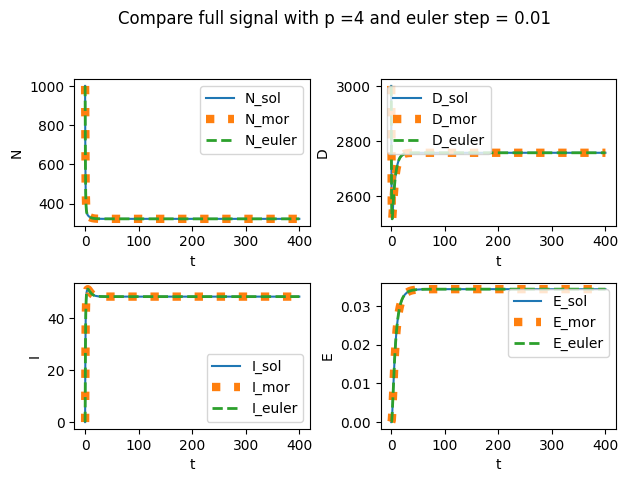

<Figure size 1000x600 with 0 Axes>

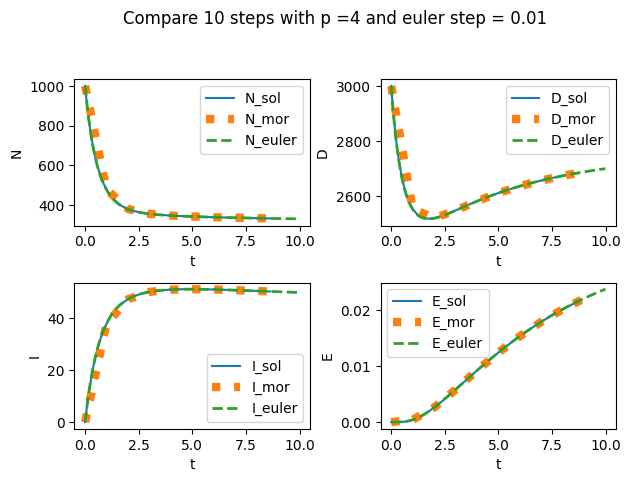

<Figure size 1000x600 with 0 Axes>

In [72]:
compare_solvers(p=4,euler_dt=0.01,mor_logger = '/content/drive/My Drive/logger_p4.csv')